# Implementation: Collect Process Data


In [32]:
!pip install psutil pandas scikit-learn joblib

In [2]:

import psutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from queue import Queue
import time
import threading
import os


In [3]:

def get_process_data():
    process_list = []
    
    for proc in psutil.process_iter(['pid', 'cpu_times', 'memory_info', 'nice']):
        try:
            info = proc.info
            process_list.append({
                "pid": info['pid'],
                "utime": info['cpu_times'].user if info['cpu_times'] else 0,  
                "stime": info['cpu_times'].system if info['cpu_times'] else 0, 
                "priority": info['nice'],  
                "mem_usage": info['memory_info'].rss if info['memory_info'] else 0  
            })
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            continue
    
    return pd.DataFrame(process_list)


df = get_process_data()
df.to_csv("windows_process_data.csv", index=False)
df.head()


,pid,utime,stime,priority,mem_usage
0,0,0.0,0.0,0,0
1,1,0.0,0.0,0,0
2,505,0.0,0.0,0,0
3,506,0.0,0.0,0,0
4,507,0.0,0.0,0,0


In [4]:
# 📌 Step 4: Train an AI Model for Process Classification
df["process_type"] = df["utime"] > df["stime"]  

X = df[["utime", "stime", "priority", "mem_usage"]]
y = df["process_type"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)


joblib.dump(model, "process_classifier.pkl")

print("✅ Model trained and saved as process_classifier.pkl")


✅ Model trained and saved as process_classifier.pkl


## REINFORCEMENT LEARNING FOR INTERNAL QUEUE LOGIC

In [5]:
import threading
import time
import csv
import psutil
import pandas as pd
import joblib
from queue import Queue

# Load trained ML model
model = joblib.load("process_classifier.pkl")

# Define Queues
cpu_queue = Queue()
io_queue = Queue()
processed_pids = set()
running = True  

# RL-related variables
state_space = ['CPU_QUEUE_SIZE', 'IO_QUEUE_SIZE']
action_space = ['PROCESS_CPU', 'PROCESS_IO']
count = 0 
last_action = None
# RL Metrics Dictionary
rl_metrics = {
    "decision_steps": 0,
    "total_reward": 0,
    "action_counts": {"PROCESS_CPU": 0, "PROCESS_IO": 0},
    "completed_tasks": {"CPU": 0, "IO": 0}
}

# Placeholder function for RL agent's decision-making
def rl_decision(state):
    global count
    if count == 3:
        count = 0
        return 'PROCESS_IO'
    elif state['CPU_QUEUE_SIZE'] > state['IO_QUEUE_SIZE']:
        count += 1
        return 'PROCESS_CPU'
    else:
        return 'PROCESS_IO'

# Classify and enqueue processes
def classify_and_enqueue():
    global processed_pids, running
    while running:
        for proc in psutil.process_iter(['pid']):
            if not running:
                break
            try:
                pid = proc.info['pid']
                if pid in processed_pids:
                    continue

                
                process_data = pd.DataFrame([{
                    "utime": proc.cpu_times().user if proc.cpu_times() else 0,
                    "stime": proc.cpu_times().system if proc.cpu_times() else 0,
                    "priority": proc.nice(),
                    "mem_usage": proc.memory_info().rss if proc.memory_info() else 0
                }])

                
                prediction = model.predict(process_data)[0]

                
                if prediction:
                    cpu_queue.put(pid)
                else:
                    io_queue.put(pid)

                processed_pids.add(pid)  
            except (psutil.NoSuchProcess, psutil.AccessDenied):
                continue
        time.sleep(5)


def process_queue(q, queue_type, execution_time=2):
    global processed_pids, running
    while running:
        if not q.empty():
            pid = q.get()
            if not psutil.pid_exists(pid):
                print(f"Skipping {queue_type} task (PID {pid} no longer exists)")
                continue

            print(f"Processing {queue_type} task: PID {pid}")
            time.sleep(execution_time)
            processed_pids.discard(pid)
            q.task_done()
            print(f"Completed {queue_type} task: PID {pid}")
        else:
            time.sleep(1)


def get_reward(state, last_action):
    reward = 0

   
    if last_action == "PROCESS_CPU":
        reward += 10  
        if state['CPU_QUEUE_SIZE'] > 100:  
            reward += 10  
        if state['CPU_QUEUE_SIZE'] > 500:  
            reward += 20 
        if state['IO_QUEUE_SIZE'] < 20:  
            reward += 5  
    
    
    if last_action == "PROCESS_IO":
        reward += 15  
        if state['IO_QUEUE_SIZE'] > 20:
            reward += 10  
        if state['IO_QUEUE_SIZE'] > 50:
            reward += 20  

    
    if state['CPU_QUEUE_SIZE'] > 500:
        reward -= 5 
    
   
    if state['IO_QUEUE_SIZE'] > 50:
        reward -= 15  

    return reward

# RL Scheduling and Queue Management
def schedule_and_manage_queues():
    global running
    global last_action
    while running:
        state = {
            'CPU_QUEUE_SIZE': cpu_queue.qsize(),
            'IO_QUEUE_SIZE': io_queue.qsize()
        }

        action = rl_decision(state)
        
        if action == 'PROCESS_CPU' and not cpu_queue.empty():
            pid = cpu_queue.get()
            print(f"RL Action: Processing CPU task with PID {pid}")
            time.sleep(2)
            cpu_queue.task_done()
            reward = get_reward(state,last_action)
            rl_metrics["total_reward"] += reward
            rl_metrics["decision_steps"] += 1
            rl_metrics["action_counts"]["PROCESS_CPU"] += 1
            rl_metrics["completed_tasks"]["CPU"] += 1
            last_action = 'PROCESS_CPU'

        elif action == 'PROCESS_IO' and not io_queue.empty():
            pid = io_queue.get()
            print(f"RL Action: Processing I/O task with PID {pid}")
            time.sleep(1)
            io_queue.task_done()
            reward = get_reward(state,last_action)
            rl_metrics["total_reward"] += reward
            rl_metrics["decision_steps"] += 1
            rl_metrics["action_counts"]["PROCESS_IO"] += 1
            rl_metrics["completed_tasks"]["IO"] += 1
            last_action = 'PROCESS_IO'

        time.sleep(1)


def log_rl_metrics():
    """ Periodically logs RL agent metrics into a CSV file """
    with open("rl_metrics_log.csv", "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Time", "Steps", "PROCESS_CPU", "PROCESS_IO", "Total Reward", "Avg Reward", "CPU Queue", "IO Queue"])

    while running:
        print("Logging metrics...") 

        if rl_metrics["decision_steps"] > 0:
            avg_reward = rl_metrics["total_reward"] / rl_metrics["decision_steps"]
        else:
            avg_reward = 0

        with open("rl_metrics_log.csv", "a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                time.strftime("%H:%M:%S"), rl_metrics["decision_steps"], 
                rl_metrics["action_counts"]["PROCESS_CPU"], 
                rl_metrics["action_counts"]["PROCESS_IO"],
                rl_metrics["total_reward"], avg_reward,
                cpu_queue.qsize(), io_queue.qsize()
            ])
            file.flush()  

        time.sleep(5) 

# Start Worker Threads
cpu_worker = threading.Thread(target=process_queue, args=(cpu_queue, "CPU-bound", 2), daemon=True)
io_worker = threading.Thread(target=process_queue, args=(io_queue, "I/O-bound", 1), daemon=True)
classifier_thread = threading.Thread(target=classify_and_enqueue, daemon=True)
scheduler_thread = threading.Thread(target=schedule_and_manage_queues, daemon=True)
log_metrics_thread = threading.Thread(target=log_rl_metrics, daemon=True)  # Logging thread

# Start all threads
cpu_worker.start()
io_worker.start()
classifier_thread.start()
scheduler_thread.start()
log_metrics_thread.start()


try:
    while True:
        print(f"CPU Queue Size: {cpu_queue.qsize()} | IO Queue Size: {io_queue.qsize()}")
        time.sleep(5)
except KeyboardInterrupt:
    print("\nStopping program...")
    running = False 
    classifier_thread.join()
    cpu_worker.join()
    io_worker.join()
    scheduler_thread.join()
    log_metrics_thread.join()
    print("All threads stopped.")


CPU Queue Size: 4 | IO Queue Size: 0
Logging metrics...
RL Action: Processing CPU task with PID 577Processing CPU-bound task: PID 804

Processing I/O-bound task: PID 823
Completed I/O-bound task: PID 823
Processing I/O-bound task: PID 824
Completed CPU-bound task: PID 804
Processing CPU-bound task: PID 805
Completed I/O-bound task: PID 824
Processing I/O-bound task: PID 835
RL Action: Processing CPU task with PID 810
Completed I/O-bound task: PID 835
Processing I/O-bound task: PID 843
Completed CPU-bound task: PID 805
Processing CPU-bound task: PID 811
Completed I/O-bound task: PID 843
Processing I/O-bound task: PID 844
CPU Queue Size: 427 | IO Queue Size: 58
Logging metrics...
Completed I/O-bound task: PID 844
Processing I/O-bound task: PID 857
Completed CPU-bound task: PID 811
Processing CPU-bound task: PID 814
RL Action: Processing CPU task with PID 816
Completed I/O-bound task: PID 857
Processing I/O-bound task: PID 861
Completed I/O-bound task: PID 861
Processing I/O-bound task: P

## Perform metrics 


In [7]:
import psutil
import pandas as pd

def get_windows_process_data():
    """ Collects process data from Windows for evaluation. """
    process_list = []
    
    for proc in psutil.process_iter(attrs=['pid', 'cpu_times', 'memory_info', 'nice']):
        try:
            info = proc.info
            process_list.append({
                "pid": info['pid'],
                "utime": info['cpu_times'].user if info['cpu_times'] else 0,  # User mode CPU time
                "stime": info['cpu_times'].system if info['cpu_times'] else 0,  # Kernel mode CPU time
                "priority": info['nice'],  # Process priority
                "mem_usage": info['memory_info'].rss if info['memory_info'] else 0  # Memory usage in bytes
            })
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            continue

    return pd.DataFrame(process_list)

# Get real-time Windows process data
df_test = get_windows_process_data()
df_test.to_csv("windows_test_data2.csv", index=False)  # Save for reuse


In [8]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


model = joblib.load("process_classifier.pkl")


df_test = pd.read_csv("windows_process_data.csv")


X_test = df_test.drop(columns=["pid"])



In [9]:
y_pred = model.predict(X_test)
df_test["predicted_class"] = y_pred
print(df_test.head())  


   pid  utime  stime  priority  mem_usage  predicted_class
0    0    0.0    0.0         0          0            False
1    1    0.0    0.0         0          0            False
2  505    0.0    0.0         0          0            False
3  506    0.0    0.0         0          0            False
4  507    0.0    0.0         0          0            False


In [31]:

df_test["true_label"] = df_test.apply(lambda row: 1 if row["utime"] + row["stime"] > 0.5 else 0, axis=1)


y_test = df_test["true_label"]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


NameError: name 'df_test' is not defined

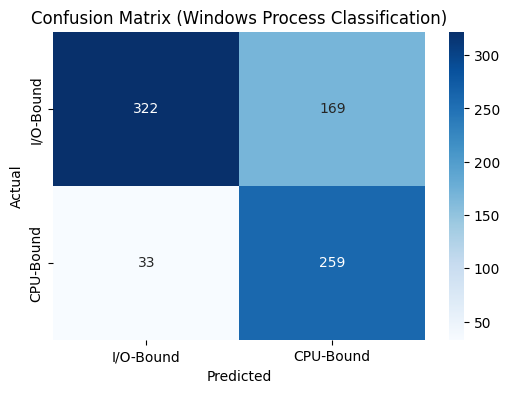

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["I/O-Bound", "CPU-Bound"], yticklabels=["I/O-Bound", "CPU-Bound"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Windows Process Classification)")
plt.show()


# DEBUGGING REQ

In [28]:
import pandas as pd

def evaluate_rl_agent(csv_file):
    """ Computes RL agent performance metrics from log data """
    
    # Load CSV file correctly, skipping any accidental header row duplication
    df = pd.read_csv(csv_file)  # Skip extra header row if needed
    
    # Ensure numerical data types
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric safely
    
    # Drop NaN rows (if any appeared due to conversion issues)
    df = df.dropna()

    # Convert necessary columns to integers
    df["PROCESS_CPU"] = df["PROCESS_CPU"].astype(int)
    df["PROCESS_IO"] = df["PROCESS_IO"].astype(int)
    df["Steps"] = df["Steps"].astype(int)
    df["CPU Queue"] = df["CPU Queue"].astype(int)
    df["IO Queue"] = df["IO Queue"].astype(int)
    df["Avg Reward"] = df["Avg Reward"].astype(float)

    # Calculate key metrics
    total_actions = df["Steps"].max()  # Total steps taken by the RL agent
    cpu_actions = df["PROCESS_CPU"].sum()  # Total CPU-bound actions
    io_actions = df["PROCESS_IO"].sum()  # Total IO-bound actions

    # Efficiency metrics
    cpu_utilization = (cpu_actions / total_actions) * 100 if total_actions > 0 else 0
    io_utilization = (io_actions / total_actions) * 100 if total_actions > 0 else 0

    # Queue balance ratio
    final_cpu_queue = df.loc[-2:-1,["CPU Queue"]]  # Last recorded CPU queue size
    final_io_queue = df.loc[-2:-1,["IO Queue"]]  # Last recorded IO queue size
    queue_balance = final_cpu_queue / (final_io_queue + 1)  # Avoid division by zero

    # Average Reward Analysis
    avg_reward = df["Avg Reward"].mean()  # Overall average reward
    max_reward = df["Avg Reward"].max()
    min_reward = df["Avg Reward"].min()

    # Processing Rate (actions per time step)
    processing_rate = total_actions / len(df) if len(df) > 0 else 0

    # Display Results
    print("🚀 RL Agent Evaluation Metrics:")
    print(f"🔹 Total Actions Taken: {total_actions}")
    print(f"🔹 CPU Actions Processed: {cpu_actions} ({cpu_utilization:.2f}%)")
    print(f"🔹 IO Actions Processed: {io_actions} ({io_utilization:.2f}%)")
    print(f"🔹 Queue Balance (CPU/IO Ratio): {queue_balance}")
    print(f"🔹 Average Reward: {avg_reward:.2f} (Min: {min_reward}, Max: {max_reward})")
    print(f"🔹 Processing Rate: {processing_rate:.2f} actions per step")




In [12]:
df = pd.read_csv("rl_metrics_log.csv")
df.columns

Index(['Time', 'Steps', 'PROCESS_CPU', 'PROCESS_IO', 'Total Reward',
       'Avg Reward', 'CPU Queue', 'IO Queue'],
      dtype='object')

In [29]:
evaluate_rl_agent("rl_metrics_log.csv")

🚀 RL Agent Evaluation Metrics:
🔹 Total Actions Taken: nan
🔹 CPU Actions Processed: 0 (0.00%)
🔹 IO Actions Processed: 0 (0.00%)
🔹 Queue Balance (CPU/IO Ratio): Empty DataFrame
Columns: [CPU Queue, IO Queue]
Index: []
🔹 Average Reward: nan (Min: nan, Max: nan)
🔹 Processing Rate: 0.00 actions per step
